In [9]:
import numpy as np
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Configurações de Caminho --
CAMINHO_DADOS_PROCESSADOS = "../data/03_processed"
CAMINHO_MODELOS = "../models"
LISTA_DE_ACOES = ["VALE3.SA", "PETR4.SA", "ITUB4.SA"] # ADICIONE AQUI SEUS TICKERS


#oblib.dump(scaler, os.path.join(CAMINHO_DADOS_PROCESSADOS, f'{TICKER_ATUAL}_scaler.joblib'))

# Cria o diretório de modelos se ele não existir
if not os.path.exists(CAMINHO_MODELOS):
    os.makedirs(CAMINHO_MODELOS)

print("Bibliotecas importadas e configurações prontas.")


# --- FUNÇÃO PRINCIPAL DE TREINAMENTO E PREVISÃO ---
def treinar_e_salvar_modelo(ticker):
    print(f"\n--- Processando o Ticker: {ticker} ---")

    # 1. Carrega os arrays e o scaler do disco
    try:
        X_train = np.load(os.path.join(CAMINHO_DADOS_PROCESSADOS, f'{ticker}_X_train.npy'))
        y_train = np.load(os.path.join(CAMINHO_DADOS_PROCESSADOS, f'{ticker}_y_train.npy'))
        X_test = np.load(os.path.join(CAMINHO_DADOS_PROCESSADOS, f'{ticker}_X_test.npy'))
        y_test = np.load(os.path.join(CAMINHO_DADOS_PROCESSADOS, f'{ticker}_y_test.npy'))

        # CARREGAR O SCALER É ESSENCIAL PARA A INVERSE_TRANSFORM!
        scaler = joblib.load(os.path.join(CAMINHO_DADOS_PROCESSADOS, f'{ticker}_scaler.joblib'))

    except FileNotFoundError as e:
        print(f"ERRO: Arquivos de dados para {ticker} não encontrados. Pule o treinamento. ({e})")
        return

    print(f"Dados carregados. X_train shape: {X_train.shape}")


    # 2. Arquitetura do Modelo (Mesma estrutura original)
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    # 3. Compilação e Early Stopping
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 4. Treinamento
    print("\nIniciando o treinamento...")
    history = model.fit(
        X_train,
        y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1 # Mantenha verbose para ver o progresso
    )
    print("Treinamento concluído!")

    # 5. Previsão do Próximo Passo
    ultima_sequencia_normalizada = X_test[-1]
    X_next_day = np.expand_dims(ultima_sequencia_normalizada, axis=0)
    previsao_normalizada = model.predict(X_next_day, verbose=0)

    # Reverter a padronização (usando o scaler carregado)
    previsao_real = scaler.inverse_transform(previsao_normalizada)
    valor_previsto = previsao_real[0][0]

    print(f"O modelo prevê que o próximo valor de '{ticker}' será de R$ {valor_previsto:.2f}")

    # 6. Salvamento do Modelo
    caminho_modelo_salvo = os.path.join(CAMINHO_MODELOS, f"{ticker}_lstm_model.keras")
    model.save(caminho_modelo_salvo)
    print(f"Melhor modelo salvo com sucesso em: '{caminho_modelo_salvo}' (Formato .keras recomendado)")

    # 7. Plotagem do Histórico (Opcional, mas útil)
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Erro de Treino (loss)')
    plt.plot(history.history['val_loss'], label='Erro de Validação (val_loss)')
    plt.title(f'Histórico de Erro do Modelo LSTM - {ticker}')
    plt.xlabel('Época')
    plt.ylabel('Erro Quadrático Médio (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

Bibliotecas importadas e configurações prontas.


Iniciando o loop de treinamento para as ações na lista...

--- Processando o Ticker: VALE3.SA ---
Dados carregados. X_train shape: (5129, 60, 1)


2025-11-07 01:22:44.006696: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



Iniciando o treinamento...
Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0064 - val_loss: 0.0160
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0017 - val_loss: 0.0181
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0013 - val_loss: 0.0103
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0011 - val_loss: 0.0216
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0010 - val_loss: 0.0099
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 8.7742e-04 - val_loss: 0.0104
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 8.6191e-04 - val_loss: 0.0056
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 8.8164e-04 - val_loss: 0.0057
Epoch 9/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 7.7798e-04 - val_loss: 0.0073
Epoch 10/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 7.6514e-04 - val_loss: 0.0087
Epoch 11/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 7.4143e

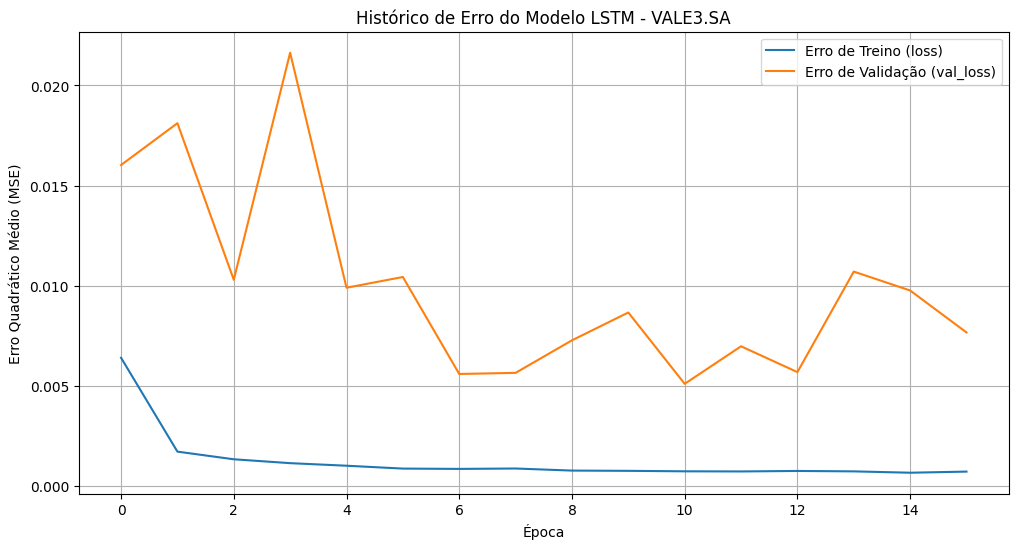


--- Processando o Ticker: PETR4.SA ---
Dados carregados. X_train shape: (5129, 60, 1)

Iniciando o treinamento...
Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0047 - val_loss: 0.0939
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0016 - val_loss: 0.0446
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0014 - val_loss: 0.0650
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0012 - val_loss: 0.0318
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0011 - val_loss: 0.0634
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0011 - val_loss: 0.0411
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0010 - val_loss: 0.0259
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0010 - val_loss: 0.0244
Epoch 9/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0010 - val_loss: 0.0128
Epoch 10/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0010 - val_loss: 0.0138
Epoc

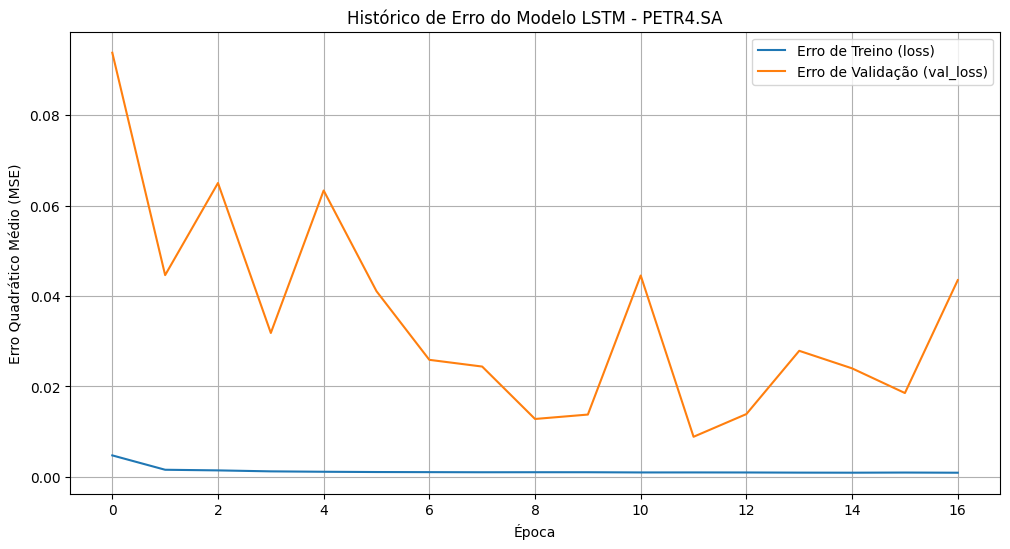


--- Processando o Ticker: ITUB4.SA ---
Dados carregados. X_train shape: (4927, 60, 1)

Iniciando o treinamento...
Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0055 - val_loss: 0.0077
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 9.5767e-04 - val_loss: 0.0121
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 8.8183e-04 - val_loss: 0.0034
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 9.0734e-04 - val_loss: 0.0031
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 8.8037e-04 - val_loss: 0.0029
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 7.1165e-04 - val_loss: 0.0029
Epoch 9/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 7.7635e-04 - val_loss: 0.0028
Epoch 10/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 6.6585

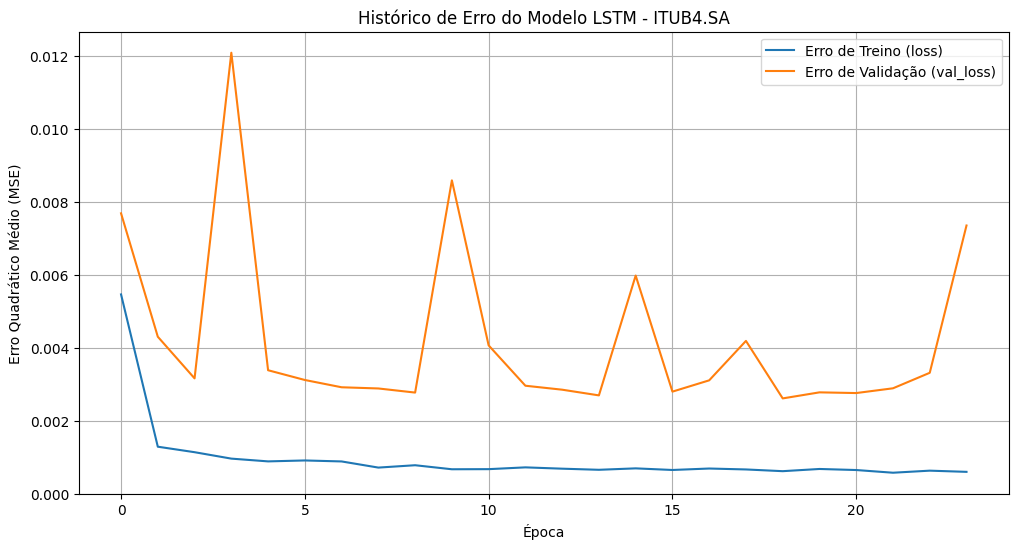



✅ Todos os treinamentos na lista foram concluídos.


In [10]:
# --- EXECUÇÃO PARA MÚLTIPLAS AÇÕES ---
print("Iniciando o loop de treinamento para as ações na lista...")

for acao in LISTA_DE_ACOES:
    # A função irá carregar os dados, treinar, prever e salvar o modelo para cada ação.
    treinar_e_salvar_modelo(acao)

print("\n\n✅ Todos os treinamentos na lista foram concluídos.")